In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import json
import pandas as pd
from tqdm import tqdm
from datetime import datetime
from geopy.geocoders import Nominatim
from shapely import wkt
from shapely.geometry import Polygon

In [ ]:
# Define location of the images and labels
xbd_dir="/content/drive/MyDrive/disaster_management_data/train"
images_dir=os.path.join(xbd_dir,"images")
labels_dir=os.path.join(xbd_dir,"labels")
train_data_info=os.path.join(xbd_dir,"xbd_data_info.csv")

In [ ]:
# Dont run if csv file is already created
#Create Dataframe
columns = ['pre_image_name', 'post_image_name', 'disaster_name', 'disaster_type',
           'disaster_location', 'num_buildings_pre', 'num_buildings_post',
           'num_no_damage', 'num_minor_damage', 'num_major_damage',
           'num_destroyed', 'num_un_classified','pre_disaster_capture_date','post_disaster_capture_date',
           'pre_image_sensor','post_image_sensor','pre_image_provider_asset_type','post_image_provider_asset_type','pre_image_GSD','post_image_GSD','pre_image_off_nadir_angle',
           'post_image_off_nadir_angle','pre_image_sun_azimuth','post_image_sun_azimuth','pre_image_sun_elevation','post_image_sun_elevation','pre_image_target_azimuth','post_image_target_azimuth',
           'pre_image_pan_resolution','post_image_pan_resolution',]
df = pd.DataFrame(columns=columns)
# Fetch values from json labels and enter into dataframe
# Dictionary to fill location for labels with missing buildings
disaster_location_info={}
# iterate through all labels files
for json_filename in tqdm(os.listdir(labels_dir)):
    # only process pre disaster json files
    if json_filename.endswith('.json') and "_pre" in json_filename:
        disaster_location=""
        # read json file
        pre_json_filepath=os.path.join(labels_dir,json_filename)
        # set post disaster json file name
        post_json_filepath = os.path.join(labels_dir, json_filename.replace("_pre", "_post"))
        # check if post disaster json file exists and skip considering current json file if post json doesn't exist
        if not os.path.exists(post_json_filepath):
            continue
        # read pre-disaster json
        with open(pre_json_filepath, 'r') as file:
            pre_data = json.load(file)
            # fetch pre-disaster image name from metadata
            pre_image_name=pre_data["metadata"]["img_name"]
            # fetch disaster event name from metadata
            disaster_name=pre_data["metadata"]["disaster"]
            # fetch disaster type from metadata
            disaster_type=pre_data["metadata"]["disaster_type"]
            # fetch pre-disaster image capture date from metadata
            pre_disaster_capture_date=datetime.fromisoformat(pre_data["metadata"]["capture_date"][:-1])
            pre_disaster_capture_date=pre_disaster_capture_date.date()
            # fetch pre-disaster image sensor from metadata
            pre_image_sensor=pre_data["metadata"]["sensor"]
            # fetch pre-disaster image provider asset type from metadata
            pre_image_provider_asset_type=pre_data["metadata"]["provider_asset_type"]
            # fetch pre-disaster image GSD from metadata
            pre_image_GSD=pre_data["metadata"]["gsd"]
            # fetch pre-disaster image off nadir angle from metadata
            pre_image_off_nadir_angle=pre_data["metadata"]["off_nadir_angle"]
            # fetch pre-disaster image sun azimuth from metadata
            pre_image_sun_azimuth=pre_data["metadata"]["sun_azimuth"]
            # fetch pre-disaster image sun elevation from metadata
            pre_image_sun_elevation=pre_data["metadata"]["sun_elevation"]
            # fetch pre-disaster image target azimuth from metadata
            pre_image_target_azimuth=pre_data["metadata"]["target_azimuth"]
            # fetch pre-disaster image pan resolution from metadata
            pre_image_pan_resolution=pre_data["metadata"]["pan_resolution"]
            # fetch lng_lat features from features
            lang_lat_features=pre_data["features"]["lng_lat"]
            # fetch number of buildings from features
            num_buildings_pre=len(pre_data["features"]["lng_lat"])
            # if any buildings exist in the image
            if num_buildings_pre>0:
                # get centroid of the location
                location_coords=lang_lat_features[0]["wkt"]
                centroid =  Polygon(wkt.loads(location_coords)).centroid
                # get location of the centroid
                geolocator = Nominatim(user_agent="geo_locator")
                location = geolocator.reverse((centroid.y, centroid.x))
                # get state/city and country from location
                if 'state' in location.raw['address']:
                    disaster_location = location.raw['address']['state'] + ", " + location.raw['address']['country']
                else:
                    disaster_location = location.raw['address']['city'] + ", " + location.raw['address']['country']
                disaster_location_info[disaster_name] = disaster_location
            # set disaster location to none if there are no buildings in the image
            else:
                disaster_location= None
        # read post-disaster json
        with open(post_json_filepath, 'r') as file:
            post_data = json.load(file)
            # fetch post-disaster image name from metadata
            post_image_name=post_data["metadata"]["img_name"]
            # fetch post-disaster image capture date from metadata
            post_disaster_capture_date=datetime.fromisoformat(post_data["metadata"]["capture_date"][:-1])
            post_disaster_capture_date=post_disaster_capture_date.date()
            # fetch post-disaster image sensor from metadata
            post_image_sensor=post_data["metadata"]["sensor"]
            # fetch post-disaster image provider asset type from metadata
            post_image_provider_asset_type=post_data["metadata"]["provider_asset_type"]
            # fetch post-disaster image GSD from metadata
            post_image_GSD=post_data["metadata"]["gsd"]
            # fetch pre-disaster image off nadir angle from metadata
            post_image_off_nadir_angle=post_data["metadata"]["off_nadir_angle"]
            # fetch pre-disaster image sun azimuth from metadata
            post_image_sun_azimuth=post_data["metadata"]["sun_azimuth"]
            # fetch pre-disaster image sun elevation from metadata
            post_image_sun_elevation=post_data["metadata"]["sun_elevation"]
            # fetch pre-disaster image target azimuth from metadata
            post_image_target_azimuth=post_data["metadata"]["target_azimuth"]
            # fetch pre-disaster image pan resolution from metadata
            post_image_pan_resolution=post_data["metadata"]["pan_resolution"]
            # fetch building features from xy features
            building_features=post_data["features"]["xy"]
            # count number of buildings from features
            num_buildings_post=len(building_features)
            # count number of buildings by damage type
            building_damage_info={"no-damage":0,"minor-damage":0,"major-damage":0,"destroyed":0,"un-classified":0}
            for feature in building_features:
                damage_type=feature["properties"]["subtype"]
                building_damage_info[damage_type] += 1
            num_no_damage=building_damage_info["no-damage"]
            num_minor_damage=building_damage_info["minor-damage"]
            num_major_damage=building_damage_info["major-damage"]
            num_destroyed=building_damage_info["destroyed"]
            num_un_classified=building_damage_info["un-classified"]
        # create dataframe row
        row_data = {
            "pre_image_name": pre_image_name,
            "post_image_name": post_image_name,
            "disaster_name": disaster_name,
            "disaster_type": disaster_type,
            "disaster_location": disaster_location,
            "num_buildings_pre": num_buildings_pre,
            "num_buildings_post": num_buildings_post,
            "num_no_damage": num_no_damage,
            "num_minor_damage": num_minor_damage,
            "num_major_damage": num_major_damage,
            "num_destroyed": num_destroyed,
            "num_un_classified": num_un_classified,
            "pre_disaster_capture_date": pre_disaster_capture_date,
            "post_disaster_capture_date": post_disaster_capture_date,
            "pre_image_sensor": pre_image_sensor,
            "post_image_sensor": post_image_sensor,
            "pre_image_provider_asset_type": pre_image_provider_asset_type,
            "post_image_provider_asset_type": post_image_provider_asset_type,
            "pre_image_GSD": pre_image_GSD,
            "post_image_GSD": post_image_GSD,
            "pre_image_off_nadir_angle": pre_image_off_nadir_angle,
            "post_image_off_nadir_angle": post_image_off_nadir_angle,
            "pre_image_sun_azimuth": pre_image_sun_azimuth,
            "post_image_sun_azimuth": post_image_sun_azimuth,
            "pre_image_sun_elevation": pre_image_sun_elevation,
            "post_image_sun_elevation": post_image_sun_elevation,
            "pre_image_target_azimuth": pre_image_target_azimuth,
            "post_image_target_azimuth": post_image_target_azimuth,
            "pre_image_pan_resolution": pre_image_pan_resolution,
            "post_image_pan_resolution": post_image_pan_resolution,
        }
        # append row to dataframe
        df=pd.concat([df, pd.DataFrame([row_data])], ignore_index=True)

100%|██████████| 5598/5598 [21:00<00:00,  4.44it/s]


In [ ]:
df.to_csv(train_data_info,index=False)

In [ ]:
# data analysis

In [ ]:
df= pd.read_csv(train_data_info)

In [ ]:
df.shape

(2799, 30)

In [ ]:
df.head()

,pre_image_name,post_image_name,disaster_name,disaster_type,disaster_location,num_buildings_pre,num_buildings_post,num_no_damage,num_minor_damage,num_major_damage,...,pre_image_off_nadir_angle,post_image_off_nadir_angle,pre_image_sun_azimuth,post_image_sun_azimuth,pre_image_sun_elevation,post_image_sun_elevation,pre_image_target_azimuth,post_image_target_azimuth,pre_image_pan_resolution,post_image_pan_resolution
0,socal-fire_00000502_pre_disaster.png,socal-fire_00000502_post_disaster.png,socal-fire,fire,NaN,0,0,0,0,0,...,15.396526,32.6742,163.75761,163.31218,42.66740,35.885086,333.27460,334.1289,0.498313,0.643838
1,socal-fire_00000488_pre_disaster.png,socal-fire_00000488_post_disaster.png,socal-fire,fire,"California, United States",22,22,14,2,0,...,15.396526,32.6742,163.75761,163.31218,42.66740,35.885086,333.27460,334.1289,0.498313,0.643838
2,socal-fire_00000501_pre_disaster.png,socal-fire_00000501_post_disaster.png,socal-fire,fire,"California, United States",23,23,7,0,3,...,15.396526,32.6742,163.75761,163.31218,42.66740,35.885086,333.27460,334.1289,0.498313,0.643838
3,socal-fire_00000522_pre_disaster.png,socal-fire_00000522_post_disaster.png,socal-fire,fire,"California, United States",2,2,0,0,0,...,21.787466,32.6742,163.63159,163.31218,42.70258,35.885086,346.04532,334.1289,0.530760,0.643838
4,socal-fire_00000465_pre_disaster.png,socal-fire_00000465_post_disaster.png,socal-fire,fire,NaN,0,0,0,0,0,...,21.787466,32.6742,163.63159,163.31218,42.70258,35.885086,346.04532,334.1289,0.530760,0.643838


In [ ]:
df['disaster_name'].unique()

array(['socal-fire', 'santa-rosa-wildfire', 'mexico-earthquake',
       'midwest-flooding', 'palu-tsunami', 'hurricane-matthew',
       'hurricane-michael', 'hurricane-florence', 'hurricane-harvey',
       'guatemala-volcano'], dtype=object)

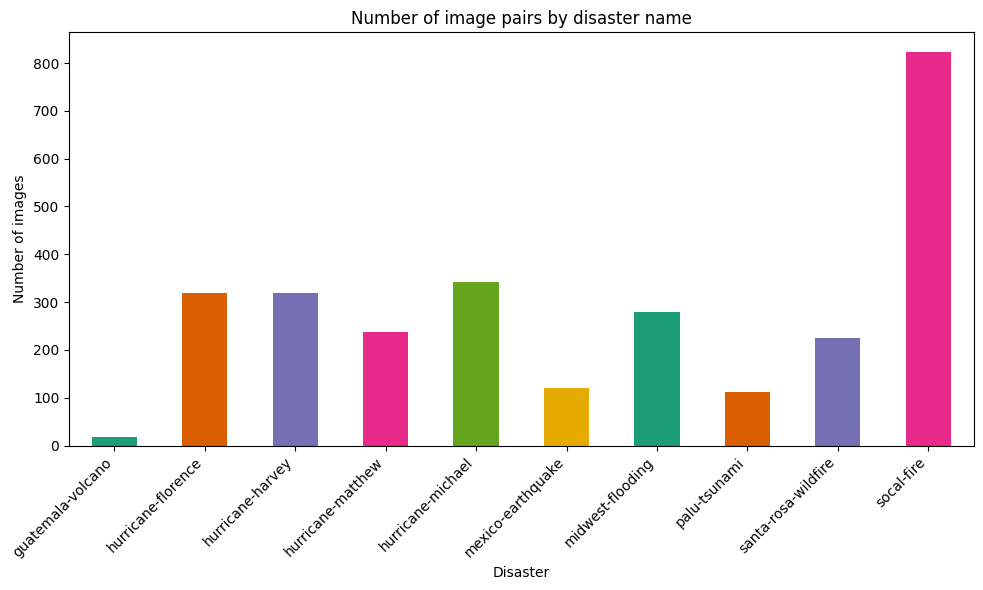

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# plot number of image pairs per disaster type
plt.figure(figsize=(10, 6))
df.groupby('disaster_name').size().plot(kind='bar', color=sns.palettes.mpl_palette('Dark2'))
plt.title('Number of image pairs by disaster name')
plt.xlabel('Disaster')
plt.ylabel('Number of images')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
df['disaster_type'].unique()

array(['fire', 'earthquake', 'flooding', 'tsunami', 'wind', 'volcano'],
      dtype=object)

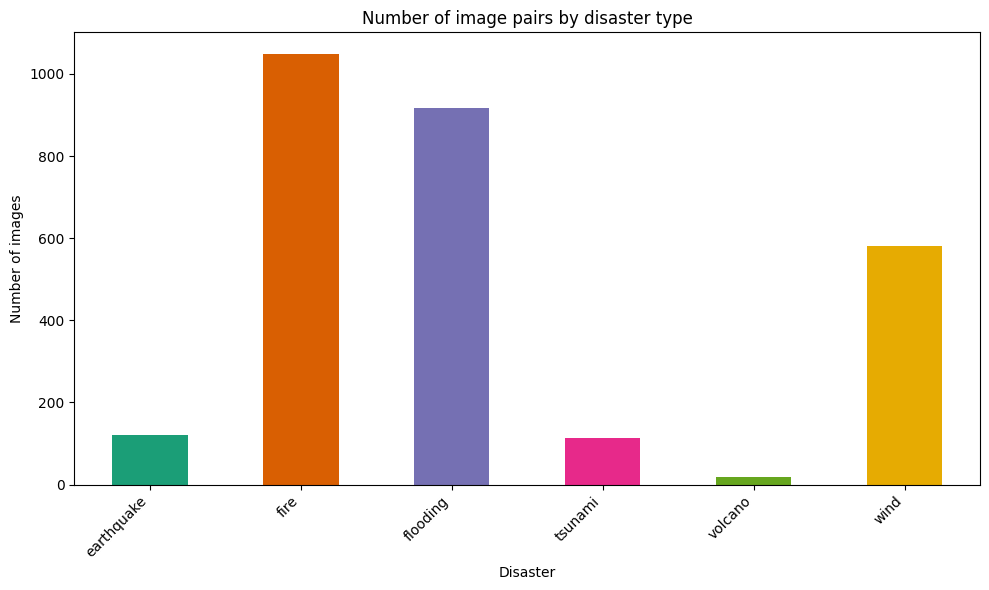

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# plot number of image pairs per disaster type
plt.figure(figsize=(10, 6))
df.groupby('disaster_type').size().plot(kind='bar', color=sns.palettes.mpl_palette('Dark2'))
plt.title('Number of image pairs by disaster type')
plt.xlabel('Disaster')
plt.ylabel('Number of images')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
df['pre_image_sensor'].unique()

array(['WORLDVIEW02', 'GEOEYE01', 'WORLDVIEW03_VNIR'], dtype=object)

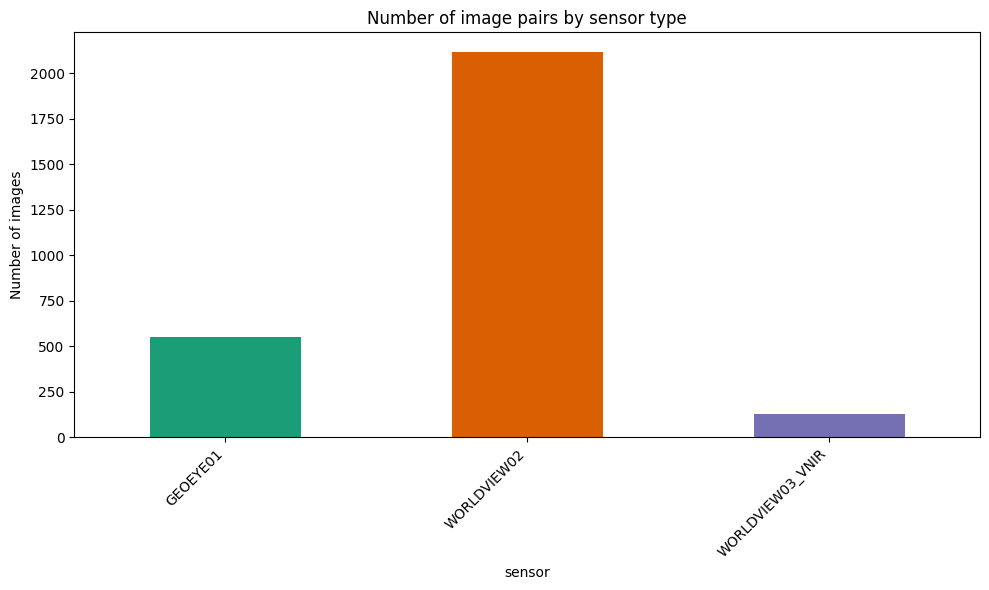

In [ ]:
# plot number of image pairs per sensor type
plt.figure(figsize=(10, 6))
df.groupby('pre_image_sensor').size().plot(kind='bar', color=sns.palettes.mpl_palette('Dark2'))
plt.title('Number of image pairs by sensor type')
plt.xlabel('sensor')
plt.ylabel('Number of images')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

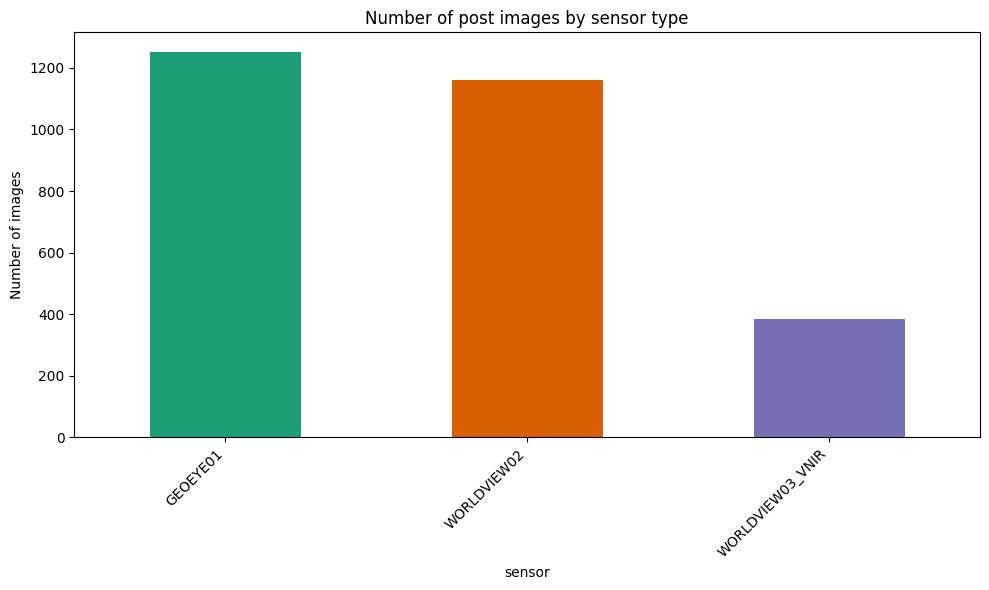

In [ ]:
# plot number of image pairs per sensor type
plt.figure(figsize=(10, 6))
df.groupby('post_image_sensor').size().plot(kind='bar', color=sns.palettes.mpl_palette('Dark2'))
plt.title('Number of post images by sensor type')
plt.xlabel('sensor')
plt.ylabel('Number of images')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
df['post_image_provider_asset_type'].unique()

array(['WORLDVIEW02', 'GEOEYE01', 'WORLDVIEW03_VNIR'], dtype=object)

(2799, 30)